In [1]:
import sys

sys.path.append('../src')
from lda import GibbsLDA, PyroLDA
from ncp import train_test_split, NCP
from ntm import NTM
from qae import VQAE
from sim import make_dataset
from slda import GibbsSLDA
from utils import show_comparison

### Latent Dirichlet Allocation

LDA: 100%|██████████| 100/100 [02:23<00:00,  1.44s/it]


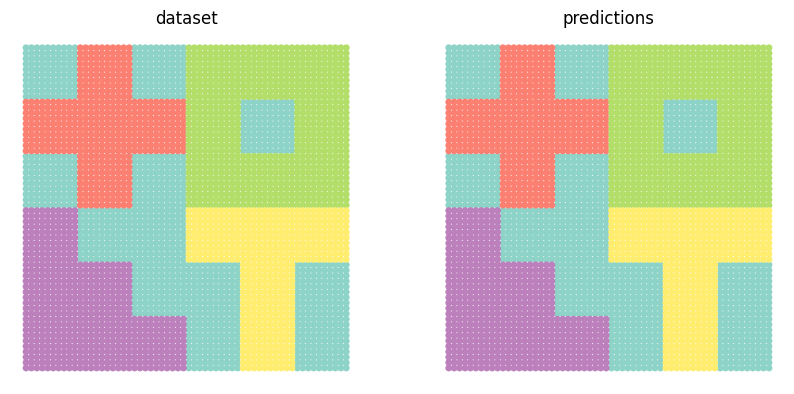

In [2]:
data, labels = make_dataset()
topics = GibbsLDA(5).fit_predict(data[:, 3:], labels)
show_comparison(data, labels, topics)

LDA: 100%|██████████| 1000/1000 [00:08<00:00, 115.94it/s]


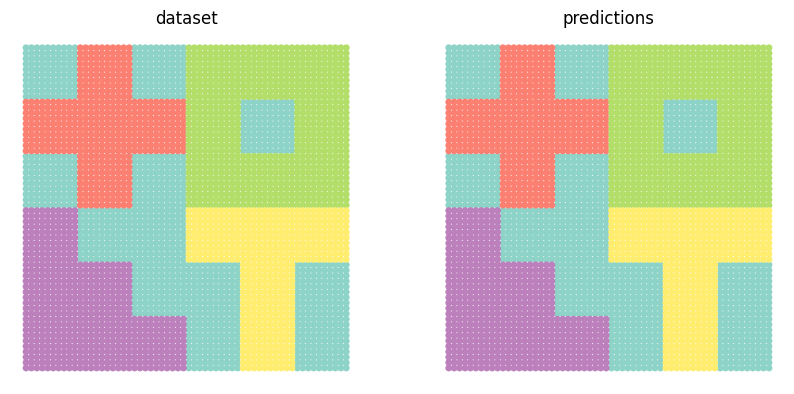

In [3]:
data, labels = make_dataset(return_tensor=True)
topics = PyroLDA(5).fit_predict(data[:, 3:], labels)
show_comparison(data, labels, topics)

### Spatial Latent Dirichlet Allocation

SLDA: 100%|██████████| 400/400 [01:32<00:00,  4.31it/s]


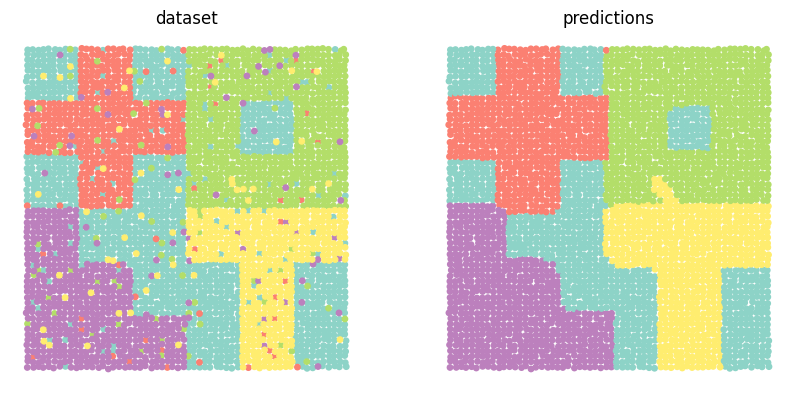

In [4]:
data, labels = make_dataset(wiggle=.1, mix=.1)
topics = GibbsSLDA(5).fit_predict(data, labels=labels)
show_comparison(data, labels, topics)

### Gaussian Softmax Neural Topic Model

NTM: 100%|██████████| 1000/1000 [00:21<00:00, 47.51it/s]


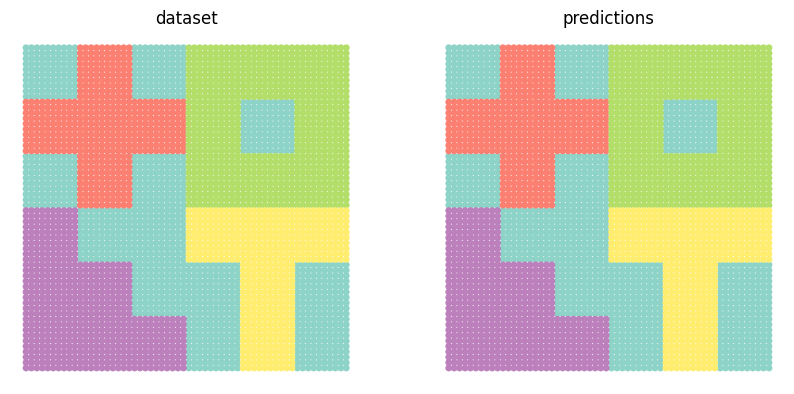

In [5]:
data, labels = make_dataset(return_tensor=True)
topics = NTM(mode='softmax').fit_predict(data, labels)
show_comparison(data, labels, topics)

### Gaussian Stick-Breaking Nueral Topic Model

NTM: 100%|██████████| 1000/1000 [00:27<00:00, 36.86it/s]


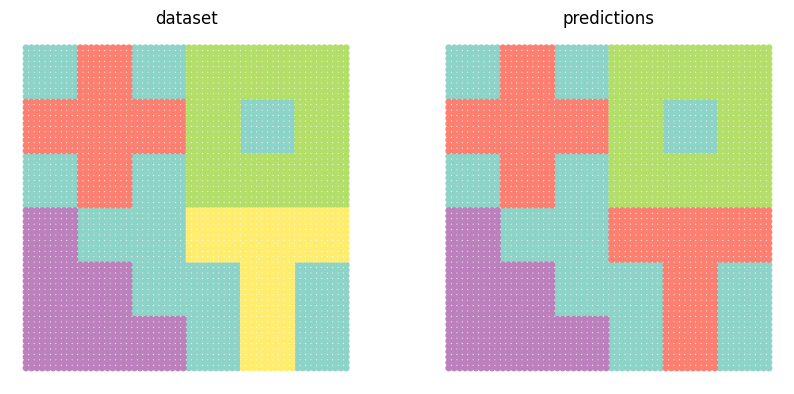

In [6]:
data, labels = make_dataset(return_tensor=True)
topics = NTM(mode='dirichlet').fit_predict(data, labels)
show_comparison(data, labels, topics)

### Vector Quantized-Autoencoder

VQAE: 100%|██████████| 100/100 [00:03<00:00, 32.20it/s]


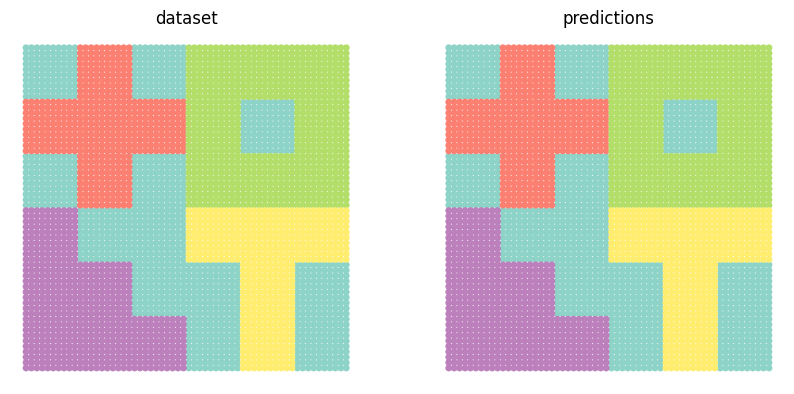

In [7]:
data, labels = make_dataset(return_tensor=True)
topics = VQAE().fit_predict(data, labels)
show_comparison(data, labels, topics)

### Neural Clustering Process

NCP: 100%|██████████| 200/200 [01:42<00:00,  1.94it/s]


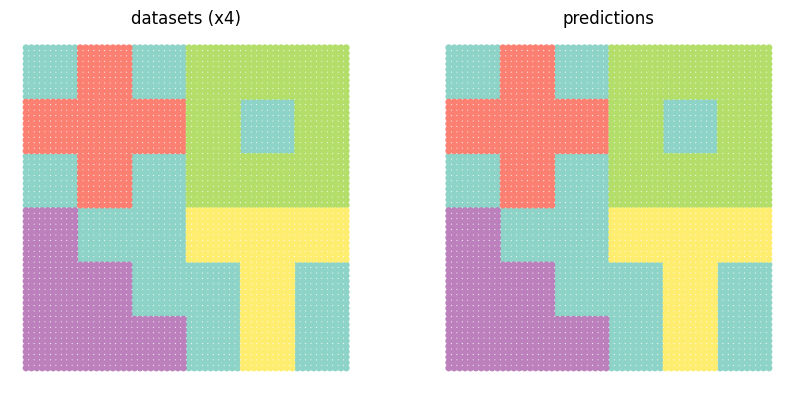

In [8]:
data, labels = make_dataset(('polygons',)*5, block_size=10, return_tensor=True)
data_train, labels_train, data_test, _ = train_test_split(data, labels)
topics = NCP().fit(data_train, labels_train)(data_test[..., 3:])
show_comparison(data_test[0], labels_train, topics, title1='datasets (x4)')